In [37]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,RSI,RSI_Strategy,BB_SMA,BB_STD,Upper_Band,Lower_Band,BB_Strategy,Full_Strategy,Strategy,Asset_Returns,Strategy_Returns
32,25.061220,25.182961,25.026437,25.182961,21800,59.166603,0.0,24.896004,0.412313,25.308318,24.483691,NaN,NaN,0,NaN,NaN
33,25.217756,25.322106,25.165582,25.165582,59300,61.417471,0.0,24.949049,0.379123,25.328172,24.569926,0.0,0.0,0,0.006246,0.000000
34,25.179588,25.319378,25.179588,25.319378,66900,62.302834,0.0,24.995838,0.343586,25.339423,24.652252,0.0,0.0,0,0.004723,0.000000
35,25.039795,25.092216,24.917479,24.934953,183400,50.787740,0.0,25.031288,0.305861,25.337149,24.725427,0.0,0.0,0,-0.000855,0.000000
36,25.092220,25.127168,25.057273,25.109694,55200,49.442905,0.0,25.070230,0.254999,25.325229,24.815231,0.0,0.0,0,0.001237,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8128,587.590027,588.979980,585.539978,587.809998,66283500,85.101285,-1.0,554.058499,20.434172,574.492671,533.624328,-1.0,-2.0,-1,22.446186,2.923093
8129,590.460022,590.969971,585.099976,585.559998,71268100,84.819878,-1.0,557.298502,20.827859,578.126360,536.470643,-1.0,-2.0,-1,22.560705,2.903931
8130,594.200012,594.500000,589.280029,591.250000,76052100,85.702537,-1.0,560.688004,21.051366,581.739369,539.636638,-1.0,-2.0,-1,22.709939,2.879204
8131,594.849976,595.539978,588.099976,588.099976,68019400,85.006047,-1.0,564.736502,19.287690,584.024192,545.448812,-1.0,-2.0,-1,22.735874,2.874961


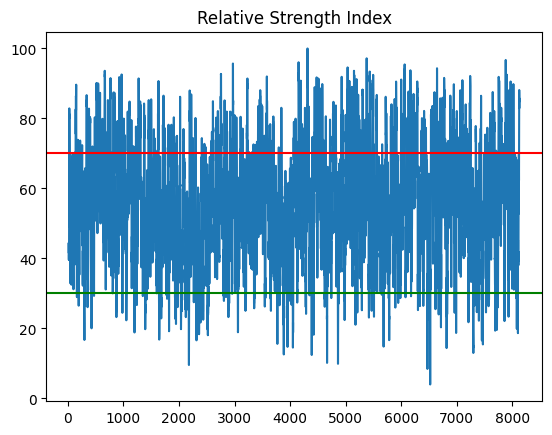

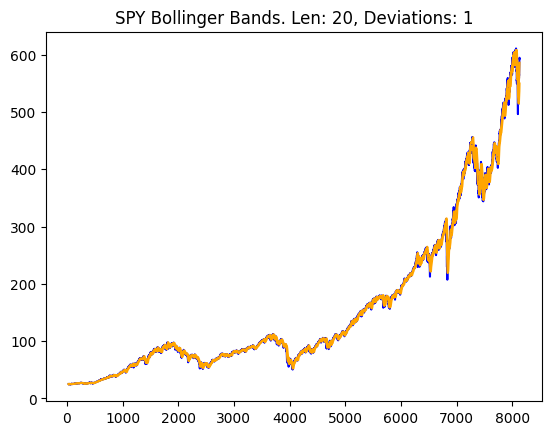

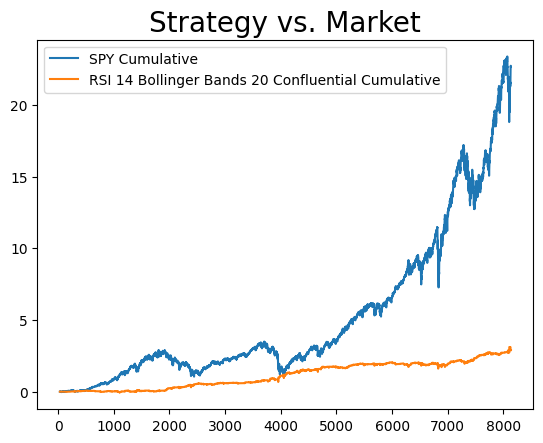

In [38]:
TICKER = 'SPY'
INTERVAL='1d'

# set period based on interval
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max'

BB_LEN = 20
DEVS = 1
RSI_LENGTH = 14
MFI_OVERSOLD = 30
RSI_OVERBOUGHT = 70
RSI_OVERSOLD = 30

# what subsetion of that data are you interested in
LOOKBACK = 10000

def get_data(ticker=TICKER, lookback=LOOKBACK, interval=INTERVAL):

    # get data at interval you want
    df = yf.download(ticker, interval=interval, period=PERIOD)
    df.columns = df.columns.get_level_values(0)

    # reset the index to make plots prettier
    df = df.reset_index(drop=True)

    # only return the subset of data you are interested in
    return df.iloc[-lookback:, :]

def add_RSI(df, length=RSI_LENGTH, overbought=RSI_OVERBOUGHT, oversold=RSI_OVERSOLD):

    price_change = df['Close'].diff()
    
    # separate gains/losses
    gain = price_change.where(price_change > 0, 0)
    loss = -price_change.where(price_change < 0, 0)

    # average gain vs loss
    avg_gain = gain.rolling(window=length).mean()
    avg_loss = loss.rolling(window=length).mean()

    # calculate rsi
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    df['RSI'] = rsi

    # plot the relative strength index
    plt.plot(df['RSI'])
    plt.axhline(overbought, color='red')
    plt.axhline(oversold, color='green')
    plt.title('Relative Strength Index')

    return df.dropna()

def add_RSI_strategy(df, overbought=RSI_OVERBOUGHT, oversold=RSI_OVERSOLD):

    df['RSI_Strategy'] = 0
    df['RSI_Strategy'] = np.where(df['RSI'] > overbought, -1, 
                     np.where(df['RSI'] < oversold, 1, 0))
    
    # shift back to make sure we have seen the signal
    df['RSI_Strategy'] = df['RSI_Strategy'].shift(1)
    return df

def add_BB(df, devs=DEVS, bb_len=BB_LEN):

    # can change to ema (use MACD video/code for reference)
    df['BB_SMA'] = df['Close'].rolling(bb_len).mean()

    # get the standard deviation of the close prices for the period
    df['BB_STD'] = df['Close'].rolling(bb_len).std()

    df['Upper_Band'] = df['BB_SMA'] + (devs * df['BB_STD'])
    df['Lower_Band'] = df['BB_SMA'] - (devs * df['BB_STD'])

    df = df.dropna()

    plt.figure()
    plt.plot(df['Close'], color='blue')
    plt.plot(df['Upper_Band'], color='orange')
    plt.plot(df['Lower_Band'], color='orange')

    plt.title(f'{TICKER} Bollinger Bands. Len: {BB_LEN}, Deviations: {DEVS}');

    return df

def add_BB_strategy(df):
    df['BB_Strategy'] = 0
    df['BB_Strategy'] = np.where(
        df['Close'] > df['Upper_Band'], -1, 
        np.where(df['Close'] < df['Lower_Band'], 1, 0)
        )
    
    df['BB_Strategy'] = df['BB_Strategy'].shift(1)
    
    return df

def add_full_strategy(df):

    df['Full_Strategy'] = df['RSI_Strategy'] + df['BB_Strategy']

    # adjust values for simplicity
    df['Strategy'] = np.where(df['Full_Strategy'] == 2, 1, 
                     np.where(df['Full_Strategy'] == -2, -1, 0))

    return df

def test_strategy(df):

    df['Asset_Returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1 + df['Close'].pct_change() * df['Strategy']).cumprod() -1

    plt.figure()
    plt.plot(df['Asset_Returns'])
    plt.plot(df['Strategy_Returns'])
    plt.legend([f'{TICKER} Cumulative', f'RSI {RSI_LENGTH} Bollinger Bands {BB_LEN} Confluential Cumulative'])
    plt.title('Strategy vs. Market', size='20')

    return df

def main():
    df = get_data()
    df = add_RSI(df)
    df = add_RSI_strategy(df)
    df = add_BB(df)
    df = add_BB_strategy(df)
    df = add_full_strategy(df)
    df = test_strategy(df)

    return df

df = main()

df